This is the code for Random Forest Regressor using dataset with enhanced molecular descriptors through RDkit. RF regressor is built using Scikit-learn framework similar to the original paper, but with hyper parameter tuning and all the best practices for machine learning. To get direct comparison, MAE and R² will be used to compare with the original paper.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from tqdm import tqdm
import shap

import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer, Normalizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier


In [122]:
df = pd.read_csv('featurized_ionic_conductivity_dataset.csv')
df

,Molality,Monomer Molecular Weight,Degree of Polymerization,CONDUCTIVITY,Mol_smiles_clean,is_valid,Topological_diameter_bonds,BRICS_unique_frag_count,BRICS_largest_frag_heavy_atoms,Fgroup_carbonyl,...,Gasteiger_std,SASA_sum,MolLogP,TPSA,NumRotatableBonds,FractionCSP3,R_eff,D,Tg,eta
0,1.4005,467.71,19.0,0.000076,COCC(CNCC(CF)OC(=O))O,True,10.0,5,4,1,...,0.233611,104.816345,-0.9056,67.79,9,0.875000,7.762332e-10,3.330923e-10,101.329,115.672374
1,1.4735,475.72,13.0,0.000070,O=C(CCNC(=O)COC(=O))NCCN,True,12.0,5,4,3,...,0.246671,108.638356,-2.2594,110.52,8,0.625000,7.806394e-10,3.312123e-10,111.676,178.396166
2,1.4422,462.68,17.0,0.000104,NC(=O)C(COC(=O))NC(=O)CCO,True,9.0,4,5,3,...,0.262205,97.331488,-2.4881,118.72,7,0.571429,7.734405e-10,3.342951e-10,113.012,197.425505
3,1.4327,476.75,16.0,0.000027,CC(COC(=O))COC(=O)C(C)(C)CO,True,10.0,4,7,2,...,0.241140,114.744238,0.3572,72.83,7,0.800000,7.812024e-10,3.309736e-10,105.241,131.387016
4,1.4680,477.69,26.0,0.000038,COC(=O)CC(=O)NC(CO)COC(=O),True,10.0,5,5,3,...,0.272433,104.758942,-1.8004,101.93,7,0.625000,7.817155e-10,3.307563e-10,111.155,177.563898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6132,1.3617,474.73,17.0,0.000037,C=CC(O)C(=O)OCCC(C)(C)OC(=O),True,10.0,4,6,2,...,0.244666,111.244694,0.4182,72.83,7,0.600000,7.800975e-10,3.314423e-10,105.039,174.773710
6133,1.4559,459.76,19.0,0.000037,C=CC(CO)NCC(CCC)OC(=O),True,8.0,4,5,1,...,0.199798,111.792457,0.4646,58.56,9,0.700000,7.718100e-10,3.350013e-10,98.688,140.781740
6134,1.3738,471.77,19.0,0.000046,C#CCCN(CC(C)OC(=O))C(C)CO,True,9.0,5,4,1,...,0.194507,117.998142,0.2540,49.77,8,0.727273,7.784728e-10,3.321341e-10,99.131,136.117963
6135,1.4559,459.76,19.0,0.000055,C=C(C)CN(CCO)CC(C)OC(=O),True,8.0,5,4,1,...,0.199169,111.944372,0.4183,49.77,8,0.700000,7.718100e-10,3.350013e-10,97.930,139.700428


In [123]:
df.describe()

,Molality,Monomer Molecular Weight,Degree of Polymerization,CONDUCTIVITY,Topological_diameter_bonds,BRICS_unique_frag_count,BRICS_largest_frag_heavy_atoms,Fgroup_carbonyl,Fgroup_ester,Fgroup_amide,...,Gasteiger_std,SASA_sum,MolLogP,TPSA,NumRotatableBonds,FractionCSP3,R_eff,D,Tg,eta
count,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,...,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6.137000e+03,6.137000e+03,6137.000000,6137.000000
mean,1.413590,460.354980,21.606159,0.000064,9.263810,4.111781,5.734724,1.557438,0.788333,0.738309,...,0.215442,107.604820,-0.285424,71.367381,7.319374,0.771800,7.719324e-10,3.350433e-10,102.989600,137.653548
std,0.075536,22.243232,6.320703,0.000052,1.524244,0.978194,1.580114,0.572627,0.519509,0.766148,...,0.025710,13.525228,0.890422,17.016340,1.588134,0.117063,1.280941e-11,5.738854e-12,4.508119,30.224829
min,1.254500,303.580000,8.000000,0.000007,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.137940,28.414920,-3.550900,20.230000,0.000000,0.285714,6.720853e-10,3.120519e-10,84.503000,84.418581
25%,1.362100,448.700000,17.000000,0.000039,8.000000,4.000000,5.000000,1.000000,0.000000,0.000000,...,0.197338,100.973564,-0.888900,58.560000,6.000000,0.714286,7.655708e-10,3.312006e-10,99.333000,112.553829
50%,1.422400,464.760000,19.000000,0.000054,9.000000,4.000000,6.000000,2.000000,1.000000,1.000000,...,0.213623,110.148447,-0.245400,72.830000,7.000000,0.777778,7.745978e-10,3.337956e-10,103.478000,133.927807
75%,1.461300,475.770000,26.000000,0.000075,10.000000,5.000000,7.000000,2.000000,1.000000,1.000000,...,0.230076,116.643582,0.252400,82.350000,8.000000,0.888889,7.806668e-10,3.377315e-10,106.033000,144.271041
max,4.368900,568.840000,76.000000,0.001571,20.000000,7.000000,13.000000,3.000000,4.000000,4.000000,...,0.329330,177.550106,4.601900,151.170000,18.000000,1.000000,8.285716e-10,3.847091e-10,121.896000,407.914798


Avg:
6.37798592797784e-05


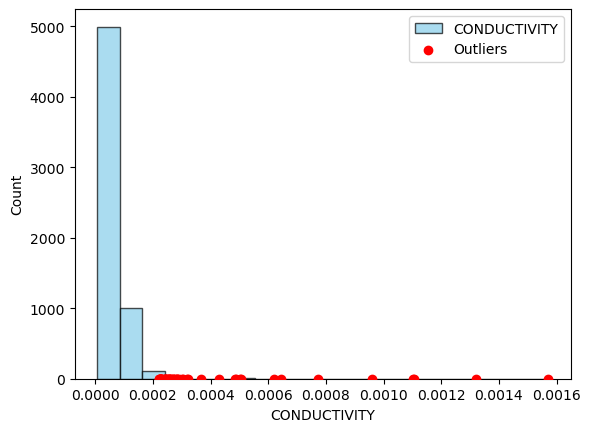

In [124]:
z_scores = np.abs(stats.zscore(df['CONDUCTIVITY']))
threshold = 3
outlier_indices = np.where(z_scores > threshold)[0]
print("Avg:")
print(df['CONDUCTIVITY'].mean())

df['CONDUCTIVITY'].plot(kind='hist',bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.scatter(df['CONDUCTIVITY'].iloc[outlier_indices], np.zeros_like(outlier_indices), color='red', zorder=5, label='Outliers')
plt.xlabel('CONDUCTIVITY')
plt.ylabel('Count')
plt.legend()
plt.show()

While we are tempted to remove outliers, these are actual data that has been created through MD with actual molecular structures. Because of their validity, I chose to keep them, but may need to represent them in a different way. Below are what happens when I plot them on a logscale instead:

Avg:
6.37798592797784e-05


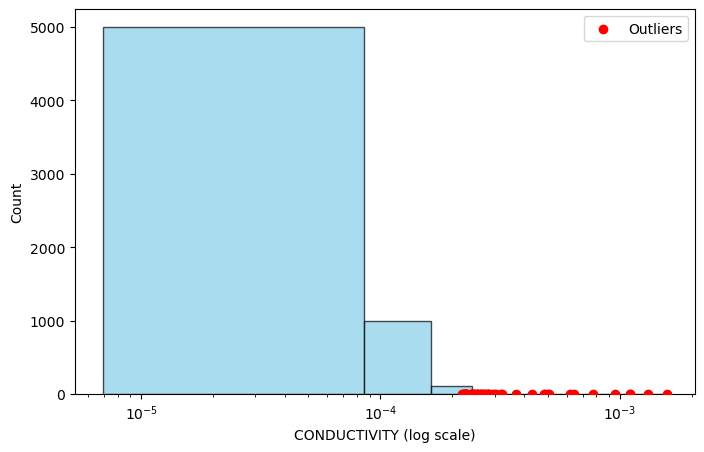

In [125]:
z_scores = np.abs(stats.zscore(df['CONDUCTIVITY']))
threshold = 3
outlier_indices = np.where(z_scores > threshold)[0]

print("Avg:")
print(df['CONDUCTIVITY'].mean())

df_nonzero = df[df['CONDUCTIVITY'] > 0]

plt.figure(figsize=(8,5))
plt.hist(df_nonzero['CONDUCTIVITY'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.scatter(df_nonzero['CONDUCTIVITY'].iloc[outlier_indices], np.zeros_like(outlier_indices), color='red', zorder=5, label='Outliers')

plt.xscale('log') 
plt.xlabel('CONDUCTIVITY (log scale)')
plt.ylabel('Count')
plt.legend()
plt.show()


It's still not very pretty but it is much easier to see in log scale where are most of the data are distributed. We can use this though! However, let's make sure to have the y values in log scale:

In [126]:
x = df.select_dtypes(include=['float64', 'int64']).drop(['CONDUCTIVITY'], axis=1).values
y = df['CONDUCTIVITY'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # we will split dataset the same amount as the original paper 

In [127]:
x_train_scaled = x_train # we are not scaling x becase random forest is scale invariant
x_test_scaled = x_test

y_train_scaled = np.log10(y_train) # for y, we will do log scaling for better representation
y_test_scaled = np.log10(y_test)

Initial run of random forest regressor will be performed first, then hyperparameters will be tuned to optimize the prediction before test set will be used.

In [128]:
# initial run of random forest with k-fold cross validation to get baseline performance

kf = KFold(n_splits=5, shuffle=True, random_state=0)
mae_list = []
r2_list = []

for train_idx, val_idx in kf.split(x_train_scaled):
    x_tr = x_train_scaled[train_idx]
    x_val = x_train_scaled[val_idx]
    y_tr = y_train_scaled[train_idx]
    y_val = y_train_scaled[val_idx]

    rf = RandomForestRegressor(n_estimators=100, random_state=0)
    rf.fit(x_tr, y_tr)
    y_pred = rf.predict(x_val)

    #y_pred = 10**y_pred_log
    #y_val_true = 10**y_val

    mae_list.append(mean_absolute_error(y_val, y_pred))
    r2_list.append(r2_score(y_val, y_pred))

mae_mean = np.mean(mae_list)
mae_std = np.std(mae_list)
r2_mean = np.mean(r2_list)
r2_std = np.std(r2_list)


In [129]:
print(f"n_estimators=100 | MAE={mae_mean:.6f} ± {mae_std:.6f} | R²={r2_mean:.4f} ± {r2_std:.4f}")

n_estimators=100 | MAE=0.124864 ± 0.002050 | R²=0.5116 ± 0.0046


In [130]:
n_estimators_list = [50, 100, 200, 500, 750]
results = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)

for n in n_estimators_list:
    mae= []
    r2 = []

    for train_idx, val_idx in kf.split(x_train_scaled):
        x_tr = x_train_scaled[train_idx]
        x_val = x_train_scaled[val_idx]
        y_tr = y_train_scaled[train_idx]
        y_val = y_train_scaled[val_idx]

        rf = RandomForestRegressor(
            n_estimators=n,
            max_features=None,
            max_depth=None,
            max_leaf_nodes=None,
            random_state=0)

        rf.fit(x_tr, y_tr)
        y_pred = rf.predict(x_val)

        mae.append(mean_absolute_error(y_val, y_pred))
        r2.append(r2_score(y_val, y_pred))

    mae_mean = np.mean(mae)
    r2_mean  = np.mean(r2)

    results.append((n, mae_mean, r2_mean))
    print(f"n_estimators={n} | mae={mae_mean:.4f} | r2={r2_mean:.4f}")

best_idx = np.argmin([r[1] for r in results])  # minimized parameter (MAE)
best_n, best_mae, best_r2 = results[best_idx]

print("\nfinal choice:")
print(f"n_estimators = {best_n}, mae={best_mae:.4f}, r2={best_r2:.4f}")

n_estimators=50 | mae=0.1256 | r2=0.5053
n_estimators=100 | mae=0.1249 | r2=0.5116
n_estimators=200 | mae=0.1247 | r2=0.5137
n_estimators=500 | mae=0.1248 | r2=0.5134
n_estimators=750 | mae=0.1247 | r2=0.5132

final choice:
n_estimators = 200, mae=0.1247, r2=0.5137


In [131]:
max_features_list = ["sqrt", "log2", 0.3, 0.5, None]
results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for mf in max_features_list:
    mae_fold = []
    r2_fold = []

    for train_idx, val_idx in kf.split(x_train_scaled):
        x_tr = x_train_scaled[train_idx]
        x_val = x_train_scaled[val_idx]
        y_tr = y_train_scaled[train_idx]
        y_val = y_train_scaled[val_idx]

        rf = RandomForestRegressor(
            n_estimators=best_n,
            max_features=mf,
            max_depth=None,
            max_leaf_nodes=None,
            random_state=0
        )

        rf.fit(x_tr, y_tr)
        y_pred = rf.predict(x_val)

        mae_fold.append(mean_absolute_error(y_val, y_pred))
        r2_fold.append(r2_score(y_val, y_pred))

    mae_mean = np.mean(mae_fold)
    r2_mean = np.mean(r2_fold)

    results.append((mf, mae_mean, r2_mean))
    print(f"max_features={mf} | MAE={mae_mean:.4f} | R2={r2_mean:.4f}")

# Pick best max_features based on lowest MAE
best_idx = np.argmin([r[1] for r in results])
best_max, best_mae, best_r2 = results[best_idx]

print("\nFinal choice:")
print(f"max_features = {best_max}, MAE={best_mae:.4f}, R2={best_r2:.4f}")


max_features=sqrt | MAE=0.1228 | R2=0.5236
max_features=log2 | MAE=0.1235 | R2=0.5185
max_features=0.3 | MAE=0.1232 | R2=0.5204
max_features=0.5 | MAE=0.1237 | R2=0.5181
max_features=None | MAE=0.1253 | R2=0.5036

Final choice:
max_features = sqrt, MAE=0.1228, R2=0.5236


In [132]:
max_depth_list = [5, 10, 20, 30, None]
results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for depth in max_depth_list:
    mae_fold = []
    r2_fold = []

    for train_idx, val_idx in kf.split(x_train_scaled):
        x_tr = x_train_scaled[train_idx]
        x_val = x_train_scaled[val_idx]
        y_tr = y_train_scaled[train_idx]
        y_val = y_train_scaled[val_idx]

        rf = RandomForestRegressor(
            n_estimators=best_n,
            max_features=best_max,
            max_depth=depth,
            max_leaf_nodes=None,
            random_state=0
        )

        rf.fit(x_tr, y_tr)
        y_pred = rf.predict(x_val)

        mae_fold.append(mean_absolute_error(y_val, y_pred))
        r2_fold.append(r2_score(y_val, y_pred))

    mae_mean = np.mean(mae_fold)
    r2_mean = np.mean(r2_fold)

    results.append((depth, mae_mean, r2_mean))
    print(f"max_depth={depth} | MAE={mae_mean:.4f} | R2={r2_mean:.4f}")

# Choose the best max_depth based on lowest MAE
best_idx = np.argmin([r[1] for r in results])
best_depth, best_mae, best_r2 = results[best_idx]

print("\nFinal choice:")
print(f"max_depth = {best_depth}, MAE={best_mae:.4f}, R2={best_r2:.4f}")


max_depth=5 | MAE=0.1349 | R2=0.4228
max_depth=10 | MAE=0.1232 | R2=0.5214
max_depth=20 | MAE=0.1227 | R2=0.5247
max_depth=30 | MAE=0.1228 | R2=0.5232
max_depth=None | MAE=0.1228 | R2=0.5236

Final choice:
max_depth = 20, MAE=0.1227, R2=0.5247


In [133]:
max_leaf_nodes_list = [2, 5, 7, 10, None]
results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for leaf in max_leaf_nodes_list:
    mae_fold = []
    r2_fold = []

    for train_idx, val_idx in kf.split(x_train_scaled):
        x_tr = x_train_scaled[train_idx]
        x_val = x_train_scaled[val_idx]
        y_tr = y_train_scaled[train_idx]
        y_val = y_train_scaled[val_idx]

        rf = RandomForestRegressor(
            n_estimators=best_n,
            max_features=best_max,
            max_depth=best_depth,
            max_leaf_nodes=leaf,
            random_state=0
        )

        rf.fit(x_tr, y_tr)
        y_pred = rf.predict(x_val)

        mae_fold.append(mean_absolute_error(y_val, y_pred))
        r2_fold.append(r2_score(y_val, y_pred))

    mae_mean = np.mean(mae_fold)
    r2_mean = np.mean(r2_fold)

    results.append((leaf, mae_mean, r2_mean))
    print(f"max_leaf_nodes={leaf} | MAE={mae_mean:.4f} | R2={r2_mean:.4f}")

# Choose the best max_leaf_nodes based on lowest MAE
best_idx = np.argmin([r[1] for r in results])
best_leaf, best_mae, best_r2 = results[best_idx]

print("\nFinal choice:")
print(f"max_leaf_nodes = {best_leaf}, MAE={best_mae:.4f}, R2={best_r2:.4f}")


max_leaf_nodes=2 | MAE=0.1618 | R2=0.1450
max_leaf_nodes=5 | MAE=0.1494 | R2=0.2827
max_leaf_nodes=7 | MAE=0.1451 | R2=0.3267
max_leaf_nodes=10 | MAE=0.1409 | R2=0.3682
max_leaf_nodes=None | MAE=0.1227 | R2=0.5247

Final choice:
max_leaf_nodes = None, MAE=0.1227, R2=0.5247


Based on hyperparameter tuning, the best hyperparameters are: 
n_estimators = 200
max_features = sqrt
max_depth = 20
max_leaf_nodes = None

In [7]:
best_n = 200
best_max = 'sqrt'
best_depth = 20
best_leaf = None

In [134]:

rf = RandomForestRegressor(n_estimators=best_n, max_features=best_max, max_depth=best_depth, max_leaf_nodes=best_leaf, random_state=0)
rf.fit(x_train_scaled, y_train_scaled)

y_test_pred = rf.predict(x_test_scaled)

mae_test = mean_absolute_error(y_test_scaled, y_test_pred)
r2_test = r2_score(y_test_scaled, y_test_pred)

print(f"Test Set Performance:")
print(f"Test MAE = {mae_test:.6f}")
print(f"Test R2   = {r2_test:.6f}")

Test Set Performance:
Test MAE = 0.122637
Test R2   = 0.558929


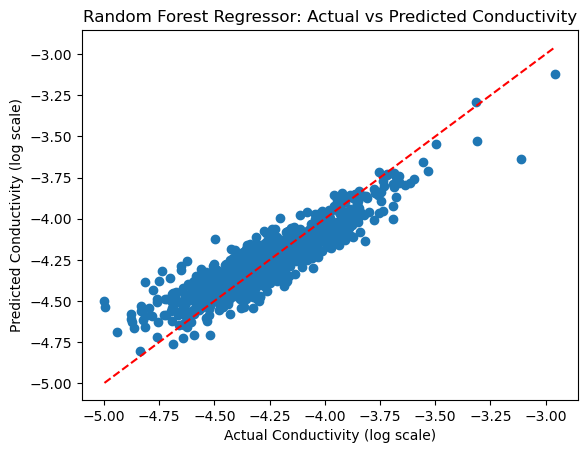

In [155]:
plt.scatter(y_test_scaled, y_test_pred)
plt.xlabel("Actual Conductivity (log scale)")
plt.ylabel("Predicted Conductivity (log scale)")
plt.title("Random Forest Regressor: Actual vs Predicted Conductivity")
plt.plot([min(y_test_scaled), max(y_test_scaled)], [min(y_test_scaled), max(y_test_scaled)], color='red', linestyle='--')
plt.show()  

Let's run feature importances of this model before comparing this with the original, MD-based dataset.

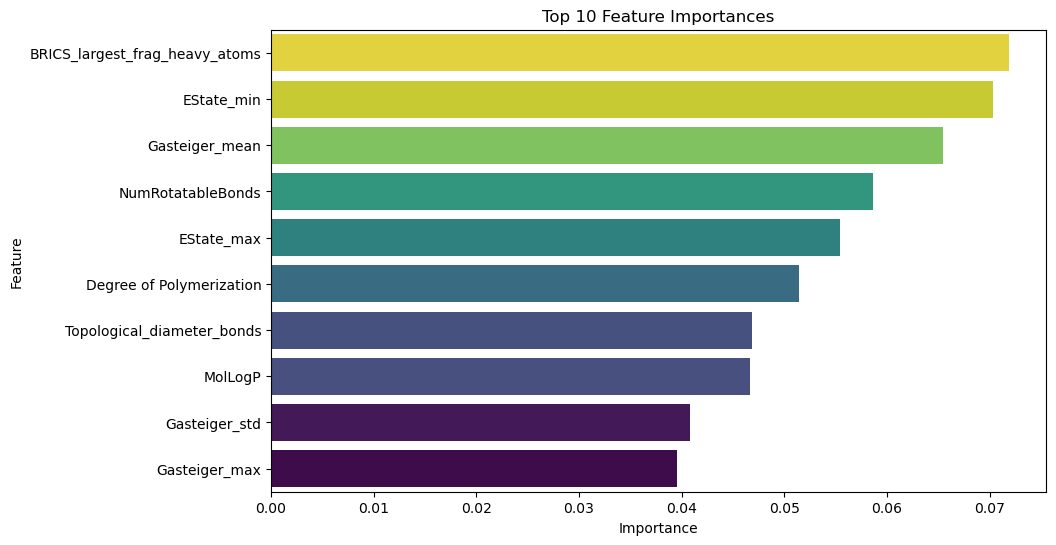

In [136]:
importances = rf.feature_importances_
features = df.select_dtypes(include=['float64', 'int64']).drop('CONDUCTIVITY', axis=1).columns

feat_df = pd.DataFrame({"feature": features, "importance": importances})
feat_df = feat_df.sort_values(by="importance", ascending=False)

top10_features = feat_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=top10_features, hue="importance", legend=False, palette="viridis")
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Now, we proceed to run the same model with the original dataset to see the performance of the model. We are expecting this to perform much better due to the MD features originally showed great correlation through Pearson Correlation Matrix.

In [137]:
df_md = pd.read_csv('TRI_data.csv')
df_md

,Trajectory ID,Mol smiles,Molality,Monomer Molecular Weight,Degree of Polymerization,Density,CONDUCTIVITY,TFSI Diffusivity,Li Diffusivity,Poly Diffusivity,Transference Number
0,9425,COCC(CNCC(CF)OC(=O)[Au])O[Cu],1.4005,467.71,19.0,1.3494,0.000076,3.229400e-08,1.260800e-08,1.526400e-08,-0.162760
1,9426,O=C(CCNC(=O)COC(=O)[Au])NCCN[Cu],1.4735,475.72,13.0,1.4561,0.000070,1.317300e-08,1.105800e-08,8.636900e-09,0.317530
2,9427,NC(=O)C(COC(=O)[Au])NC(=O)CCO[Cu],1.4422,462.68,17.0,1.5336,0.000104,1.397400e-08,1.952200e-08,9.183200e-09,0.529740
3,9428,CC(COC(=O)[Au])COC(=O)C(C)(C)CO[Cu],1.4327,476.75,16.0,1.2767,0.000027,2.421000e-08,1.192500e-08,1.402700e-08,-0.319160
4,9429,COC(=O)CC(=O)NC(CO[Cu])COC(=O)[Au],1.4680,477.69,26.0,1.4896,0.000038,1.349100e-08,6.582900e-09,8.672500e-09,0.080645
...,...,...,...,...,...,...,...,...,...,...,...
6132,29789,C=CC(O[Cu])C(=O)OCCC(C)(C)OC(=O)[Au],1.3617,474.73,17.0,1.2898,0.000037,2.621800e-08,1.083600e-08,1.632100e-08,-0.670610
6133,29790,C=CC(CO[Cu])NCC(CCC)OC(=O)[Au],1.4559,459.76,19.0,1.2026,0.000037,2.438100e-08,2.447000e-08,2.782100e-08,0.345690
6134,29791,C#CCCN(CC(C)OC(=O)[Au])C(C)CO[Cu],1.3738,471.77,19.0,1.2302,0.000046,3.741000e-08,2.431500e-08,1.979900e-08,-0.096209
6135,29792,C=C(C)CN(CCO[Cu])CC(C)OC(=O)[Au],1.4559,459.76,19.0,1.2254,0.000055,4.686200e-08,2.154000e-08,3.485500e-08,-0.511600


In [138]:
df_md.describe()

,Trajectory ID,Molality,Monomer Molecular Weight,Degree of Polymerization,Density,CONDUCTIVITY,TFSI Diffusivity,Li Diffusivity,Poly Diffusivity,Transference Number
count,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6.137000e+03,6.137000e+03,6.137000e+03,6137.000000
mean,23341.232524,1.413590,460.354980,21.606159,1.307436,0.000064,2.857119e-08,1.750424e-08,1.780116e-08,0.055919
std,6421.665395,0.075536,22.243232,6.320703,0.101767,0.000052,1.838611e-08,1.163738e-08,1.610993e-08,0.286190
min,9425.000000,1.254500,303.580000,8.000000,1.105000,0.000007,5.691800e-09,3.168400e-09,2.804700e-09,-1.641900
25%,14625.000000,1.362100,448.700000,17.000000,1.228300,0.000039,1.706900e-08,1.111700e-08,9.141700e-09,-0.087684
50%,26571.000000,1.422400,464.760000,19.000000,1.298100,0.000054,2.415900e-08,1.538300e-08,1.344000e-08,0.106870
75%,28244.000000,1.461300,475.770000,26.000000,1.358500,0.000075,3.572600e-08,2.134100e-08,2.228100e-08,0.253060
max,29793.000000,4.368900,568.840000,76.000000,1.974200,0.001571,3.663600e-07,2.841100e-07,3.618000e-07,0.841420


In [139]:
x = df_md.select_dtypes(include=['float64', 'int64']).drop(['CONDUCTIVITY'], axis=1).values
y = df_md['CONDUCTIVITY'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # we will split dataset the same amount as the original paper 

In [140]:
x_train_scaled = x_train
x_test_scaled = x_test

y_train_scaled = np.log10(y_train)
y_test_scaled = np.log10(y_test)

In [141]:
rf = RandomForestRegressor(n_estimators=best_n, max_features=best_max, max_depth=best_depth, max_leaf_nodes=best_leaf, random_state=0)
rf.fit(x_train_scaled, y_train_scaled)

y_test_pred = rf.predict(x_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_test_pred)
r2_test = r2_score(y_test_scaled, y_test_pred)

print(f"Test Set Performance:")
print(f"Test MAE = {mae_test:.6f}")
print(f"Test R2   = {r2_test:.6f}")

Test Set Performance:
Test MAE = 0.087742
Test R2   = 0.746819


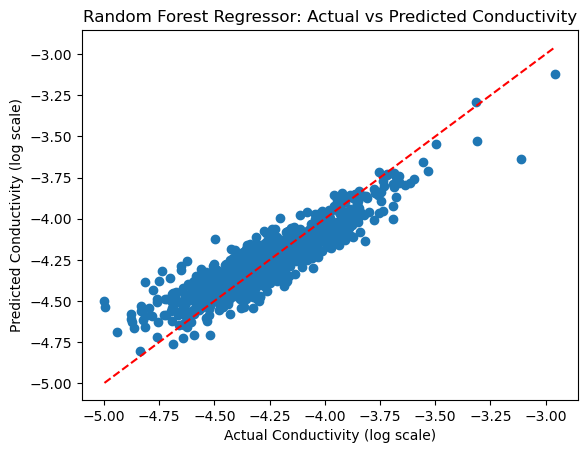

In [156]:
plt.scatter(y_test_scaled, y_test_pred)
plt.xlabel("Actual Conductivity (log scale)")
plt.ylabel("Predicted Conductivity (log scale)")
plt.title("Random Forest Regressor: Actual vs Predicted Conductivity")
plt.plot([min(y_test_scaled), max(y_test_scaled)], [min(y_test_scaled), max(y_test_scaled)], color='red', linestyle='--')
plt.show()  

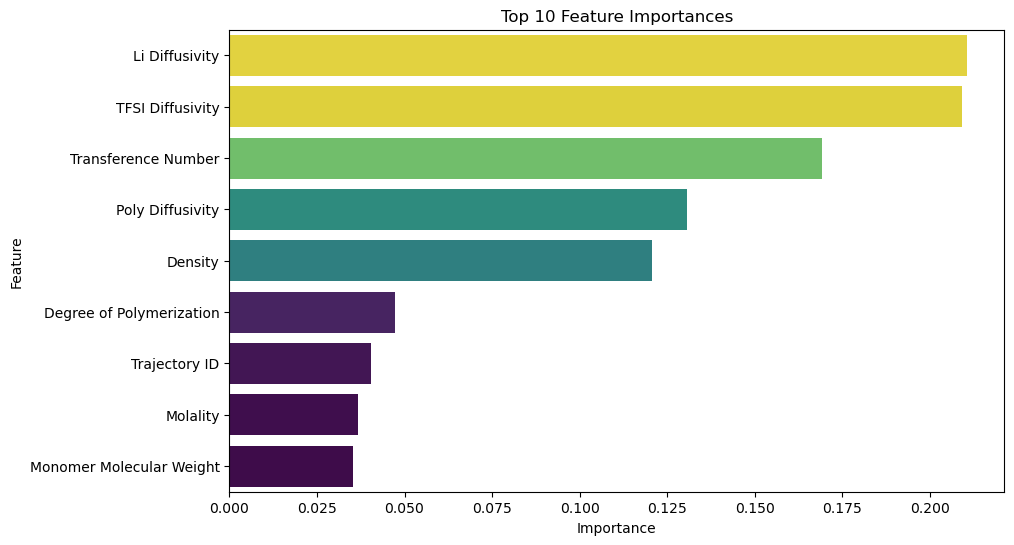

In [143]:
importances = rf.feature_importances_
features = df_md.select_dtypes(include=['float64', 'int64']).drop('CONDUCTIVITY', axis=1).columns

feat_df = pd.DataFrame({"feature": features, "importance": importances})
feat_df = feat_df.sort_values(by="importance", ascending=False)

top10_features = feat_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=top10_features, hue="importance", legend=False, palette="viridis")
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

Finally, we will combine RDkit features with the MD features as one dataset and use this model prediction to see if MAE will improve significantly. This is the most exciting part!!

In [3]:
df_full = pd.read_csv('full_ionic_conductivity_dataset.csv')
df_full

,Trajectory ID,Mol smiles,Molality,Monomer Molecular Weight,Degree of Polymerization,Density,CONDUCTIVITY,TFSI Diffusivity,Li Diffusivity,Poly Diffusivity,...,Gasteiger_std,SASA_sum,MolLogP,TPSA,NumRotatableBonds,FractionCSP3,R_eff,D,Tg,eta
0,9425,COCC(CNCC(CF)OC(=O)[Au])O[Cu],1.4005,467.71,19.0,1.3494,0.000076,3.229400e-08,1.260800e-08,1.526400e-08,...,0.233611,104.816345,-0.9056,67.79,9,0.875000,7.762332e-10,3.330923e-10,101.329,115.672374
1,9426,O=C(CCNC(=O)COC(=O)[Au])NCCN[Cu],1.4735,475.72,13.0,1.4561,0.000070,1.317300e-08,1.105800e-08,8.636900e-09,...,0.246671,108.638356,-2.2594,110.52,8,0.625000,7.806394e-10,3.312123e-10,111.676,178.396166
2,9427,NC(=O)C(COC(=O)[Au])NC(=O)CCO[Cu],1.4422,462.68,17.0,1.5336,0.000104,1.397400e-08,1.952200e-08,9.183200e-09,...,0.262205,97.331488,-2.4881,118.72,7,0.571429,7.734405e-10,3.342951e-10,113.012,197.425505
3,9428,CC(COC(=O)[Au])COC(=O)C(C)(C)CO[Cu],1.4327,476.75,16.0,1.2767,0.000027,2.421000e-08,1.192500e-08,1.402700e-08,...,0.241140,114.744238,0.3572,72.83,7,0.800000,7.812024e-10,3.309736e-10,105.241,131.387016
4,9429,COC(=O)CC(=O)NC(CO[Cu])COC(=O)[Au],1.4680,477.69,26.0,1.4896,0.000038,1.349100e-08,6.582900e-09,8.672500e-09,...,0.272433,104.758942,-1.8004,101.93,7,0.625000,7.817155e-10,3.307563e-10,111.155,177.563898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6132,29789,C=CC(O[Cu])C(=O)OCCC(C)(C)OC(=O)[Au],1.3617,474.73,17.0,1.2898,0.000037,2.621800e-08,1.083600e-08,1.632100e-08,...,0.244666,111.244694,0.4182,72.83,7,0.600000,7.800975e-10,3.314423e-10,105.039,174.773710
6133,29790,C=CC(CO[Cu])NCC(CCC)OC(=O)[Au],1.4559,459.76,19.0,1.2026,0.000037,2.438100e-08,2.447000e-08,2.782100e-08,...,0.199798,111.792457,0.4646,58.56,9,0.700000,7.718100e-10,3.350013e-10,98.688,140.781740
6134,29791,C#CCCN(CC(C)OC(=O)[Au])C(C)CO[Cu],1.3738,471.77,19.0,1.2302,0.000046,3.741000e-08,2.431500e-08,1.979900e-08,...,0.194507,117.998142,0.2540,49.77,8,0.727273,7.784728e-10,3.321341e-10,99.131,136.117963
6135,29792,C=C(C)CN(CCO[Cu])CC(C)OC(=O)[Au],1.4559,459.76,19.0,1.2254,0.000055,4.686200e-08,2.154000e-08,3.485500e-08,...,0.199169,111.944372,0.4183,49.77,8,0.700000,7.718100e-10,3.350013e-10,97.930,139.700428


In [4]:
x = df_full.select_dtypes(include=['float64', 'int64']).drop(['CONDUCTIVITY'], axis=1).values
y = df_full['CONDUCTIVITY'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) # we will split dataset the same amount as the original paper 

In [5]:
x_train_scaled = x_train
x_test_scaled = x_test

y_train_scaled = np.log10(y_train)
y_test_scaled = np.log10(y_test)

In [8]:
rf = RandomForestRegressor(n_estimators=best_n, max_features=best_max, max_depth=best_depth, max_leaf_nodes=best_leaf, random_state=0)
rf.fit(x_train_scaled, y_train_scaled)

y_test_pred = rf.predict(x_test_scaled)
mae_test = mean_absolute_error(y_test_scaled, y_test_pred)
r2_test = r2_score(y_test_scaled, y_test_pred)

print(f"Test Set Performance:")
print(f"Test MAE = {mae_test:.6f}")
print(f"Test R2   = {r2_test:.6f}")

Test Set Performance:
Test MAE = 0.078135
Test R2   = 0.805647


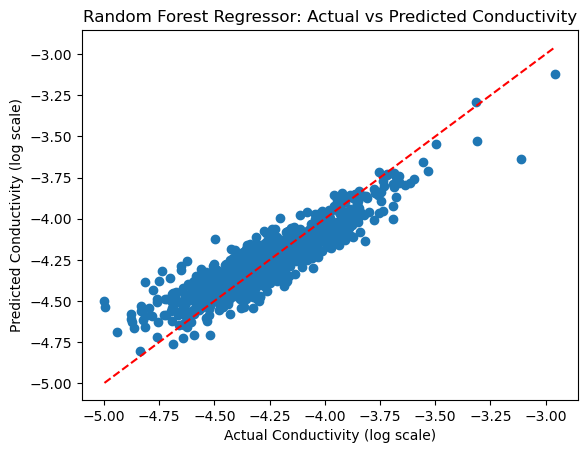

In [9]:
plt.scatter(y_test_scaled, y_test_pred)
plt.xlabel("Actual Conductivity (log scale)")
plt.ylabel("Predicted Conductivity (log scale)")
plt.title("Random Forest Regressor: Actual vs Predicted Conductivity")
plt.plot([min(y_test_scaled), max(y_test_scaled)], [min(y_test_scaled), max(y_test_scaled)], color='red', linestyle='--')
plt.show()  

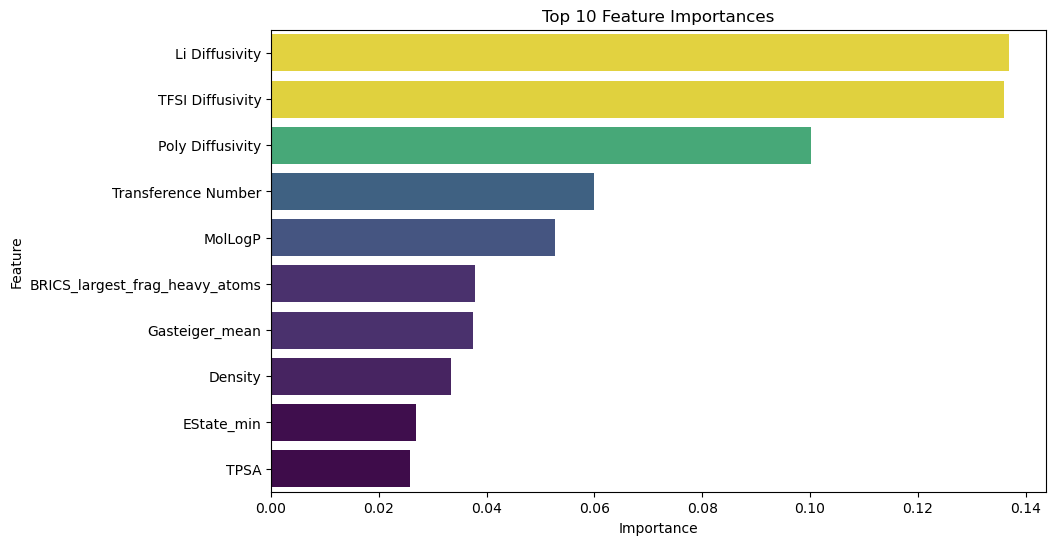

In [10]:
importances = rf.feature_importances_
features = df_full.select_dtypes(include=['float64', 'int64']).drop(['CONDUCTIVITY'], axis=1).columns

feat_df = pd.DataFrame({"feature": features, "importance": importances})
feat_df = feat_df.sort_values(by="importance", ascending=False)

top10_features = feat_df.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=top10_features, hue="importance", legend=False, palette="viridis")
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()